<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Avanzados en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Practical Assignment: Support Vector Machines</div><br>
    <div style="font-size: large">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div><br>
    <div>Luis Antonio Ortega Andrés - Antonio Coín Castro</div><br></div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [9]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook).

In [11]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from Utils import plot_dataset_clas, plot_svc

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the SVC class of `sklearn`.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

# SMO Algorithm

## Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

## SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this type of divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:
\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

## Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

## Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide a larger minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

## Stopping Criteria

The algorithm will be terminated when a certain maximum number of iteration is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

## Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

## Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b^* . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

# Implementation of the SVC

## Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma='scale', tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs, each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X, y)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, X)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector

---
```python
predict(self, X)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

## Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bound $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

## Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [48]:
from sys import exit
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import linear_kernel

class MySVC():
    """
    SVC with a simplified version of SMO.
    """

    def __init__(self,
                 C = 1.0,
                 gamma = 'scale',
                 kernel = 'rbf',
                 tol = 1e-3,
                 max_iter = 100,
                 random_state = 123):
        """
        Construct a SVC model.
          - C: regularization parameter. The strength of the regularization is
            proportional to C.
          - gamma: kernel coefficient.
          - kernel: callable with signature kernel(X, Y=None) that takes two
            matrices and returns the kernel Gram matrix; or one of 'linear' or 'rbf'.
            If the kernel is a function, the rest of the parameters should be fixed before
            constructing the model.
          - tol: tolerance for stopping condition.
          - max_iter: maximum number of iterations for SMO.
          - random_state: seed for randomness.
        """

        # Assignment of hyper-parameters.
        self.C = C
        self.gamma = gamma
        self.kernel = kernel
        self.tol = tol
        self.max_iter = max_iter
        self.intercept = None
        self.random_state = random_state
        self.fit_status_ = 1

    def fit(self, X, y):
        """
        Fit a model with the SMO algorithm.
          - X: a Nxd-matrix contaning the N d-dimensional training points.
          - y: a N-vector containing the labels of each training example (-1 or 1).
        """

        np.random.seed(self.random_state)
        N, d = X.shape

        # Options for gamma (for compatibility with sklean).
        if (self.gamma == 'scale'):
            X_var = X.var()
            self.gamma = 1.0 / (d * X_var) if X_var != 0 else 1.0
        if (self.gamma == 'auto'):
            self.gamma = 1.0 / d

        # Initialization of the dual coefficients.
        a = np.zeros(N)

        # Check kernel function
        if self.kernel == 'rbf':
            self.kernel_ = lambda X, Y: rbf_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'linear':
            self.kernel_ = lambda X, Y: linear_kernel(X, Y)
        elif callable(self.kernel):
            self.kernel_ = self.kernel
        else:
            print("[Error]: Not a valid kernel.")
            exit()
            

        # Pre-compute all kernel configurations (optimized for self-distances matrix).
        K = self.kernel_(X, None)

        # Loop over the iterations.
        for it in range(self.max_iter):
            # Save the old dual coefficients for later use in convergence criterion.
            a_old = a.copy()

            # Compute all pairs of indices
            ix = np.arange(N)
            jx = [np.random.choice(ix[ix != i]) for i in ix]

            # As k depends only on the kernel, it can be pre-computed outside the loop.
            k = np.array([2 * K[i, j] - K[i, i] - K[j, j] for i, j in zip(ix, jx)])

            # Loop over the indices.
            for i, j in zip(ix, jx):
                # If k=0 we skip the update
                if k[i] == 0:
                    continue

                # Compute d
                Ei = self._compute_energy(K, y, a, i)
                Ej = self._compute_energy(K, y, a, j)
                d = y[j] * (Ej - Ei) / k[i]

                # Compute bounds
                L, H = self._compute_bounds(i, j, a, y[i] != y[j])

                # Update the corresponding dual coefficients
                aj_new = np.minimum(np.maximum(a[j] + d, L), H)
                a[i] = a[i] - y[i] * y[j] * (aj_new - a[j])
                a[j] = aj_new

            # Check stopping condition.
            if np.linalg.norm(a - a_old) < self.tol:
                break

        # Compute the intercept.
        support_hyperplane_indices = np.where((a > 0.0) & (a < self.C))
        self.intercept_ = np.mean([
            y[k] - (a * y) @ K[:, k]
            for k in support_hyperplane_indices
        ])

        # Save model attributes mimicking sklearn syntax
        self.support_ = np.where(a > 0.0)
        self.support_vectors_ = X[self.support_]
        self.n_support_ = np.array([sum((a > 0.0) & (y == c)) for c in [-1, 1]])
        self.dual_coef_ = a[self.support_] * y[self.support_]
        self.coef_ = None
        self.fit_status_ = 0
        self.classes_ = np.array([-1, 1])
        self.shape_fit_ = X.shape

        # In the linear case we can recover the weights 'w' of the primal solution
        if self.kernel == 'linear':
            self.coef_ = (a * y) @ X

        return self

    def _compute_energy(self, K, y, a, i):
        return (a * y) @ K[:, i] - y[i]

    def _compute_bounds(self, i, j, a, condition):
        # Compute lower bound
        L = max(0, a[j] - a[i]) if condition else max(
            0, a[j] + a[i] - self.C)

        # Computer upper bound
        H = min(self.C, self.C - a[i] + a[j]) if condition else min(
            self.C, a[i] + a[j])

        return L, H

    def decision_function(self, X):
        """
        Computation of the decision function over X.
        """
        
        if self.fit_status_ != 0:
            print("[Error]: Model is not fitted.")
            exit()
        else:
            return self.dual_coef_ @ self.kernel_(self.support_vectors_, X) + self.intercept_

    def predict(self, X):
        """
        Computation of the predicted class over X.
        """
        
        if self.fit_status_ != 0:
            print("[Error]: Model is not fitted.")
            exit()
        else:
            return np.sign(self.decision_function(X))

    def score(self, X, y):
        """
        Computation of the classfication accuracy over (X,y).
        """
        
        if self.fit_status_ != 0:
            print("[Error]: Model is not fitted.")
            exit()
        else:
            return np.mean(self.predict(X) == y)

# Experiments with the SVC

## Comparative with *scikit-learn*

The following cell generates the *moons* dataset with one hundred 2-dimensional points, dividing it into train and test splits, and depicting it.

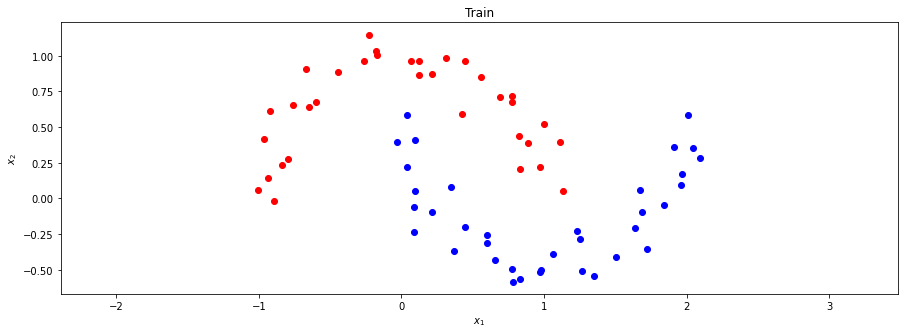

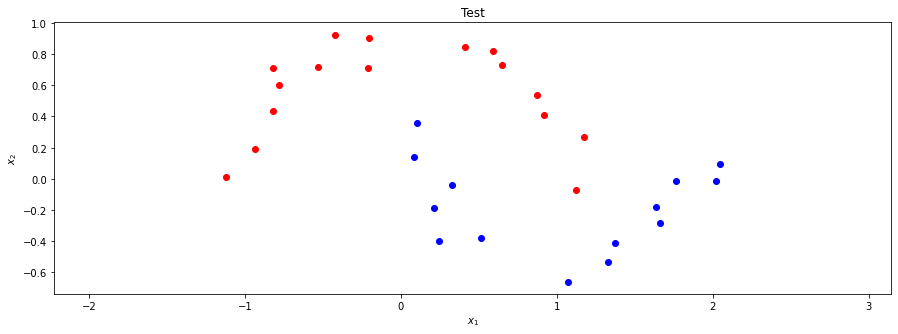

In [13]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

x, y = make_moons(noise=1e-1, random_state=seed)
y[y != 1] = -1

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=seed)

plot_dataset_clas(x_tr, y_tr)
plt.title('Train'); plt.show()
plot_dataset_clas(x_te, y_te)
plt.title('Test'); plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of `sklearn` and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results. If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

In [82]:
import time

def compare_svc(x_tr, y_tr, x_te, y_te, C=1, kernel='rbf', tol=1e-3, max_iter=100, seed =123):
    """
    Compare the MySVC method to Sklearn's SVC method.
    """
    
    model_my = MySVC(C=C, kernel=kernel, random_state = seed, tol=tol, max_iter=max_iter)
    model_sk = SVC(C=C, kernel=kernel, random_state = seed)

    # Training of the models.
    t = time.process_time()
    model_my.fit(x_tr, y_tr)
    print("Training time for MySVC:", (time.process_time() - t) * 1000, "ms")
    t = time.process_time()
    model_sk.fit(x_tr, y_tr)
    print("Training time for Sklearn:", (time.process_time() - t) * 1000, "ms")
    
    # When using a custom kernel in Sklearn, the field support_vectors_ is empty.
    if callable(kernel):
        model_sk.support_vectors_ = x_tr[model_sk.support_]

    # Show supporting hyperplane, decision boundary and support vectors
    print("\nMySVC model:")
    plot_svc(x_tr, y_tr, model_my)
    print("Sklearn model:")
    plot_svc(x_tr, y_tr, model_sk)

    # Comparative of the predicted classes
    predict_my = model_my.predict(x_te)
    predict_sk = model_sk.predict(x_te)
    print("% of predicted classes that coincide in both models:",
          np.mean(predict_my == predict_sk)*100, "%")

    # Comparative of the predicted scores
    score_my = model_my.score(x_te, y_te)
    score_sk = model_sk.score(x_te, y_te)
    print("Accuracy score in MySVC:", score_my * 100, "%")
    print("Accuracy score in Sklearn:", score_sk * 100, "%")

    # Comparative of support vectors for each class [-1, 1]
    print("Number of support vectors (for each class) in MySVC:", model_my.n_support_)
    print("Number of support vectors (for each class) in Sklearn:", model_sk.n_support_)

    # Comparative of primal coefficients
    if kernel == 'linear':
        print("Linear model coefficients (w) in MySVC:", model_my.coef_)
        print("Linear model coefficients (w) in Sklearn:", model_sk.coef_)

First of all we compare our implementation and Sklearn's in terms of a linear kernel (the simplest one), given by

$$
\mathcal{K}(\mathbf{x}, \mathbf{x'})=\mathbf{x}^T\mathbf{x'}.
$$

Training time for MySVC: 125.54698099999939 ms
Training time for Sklearn: 2.3056759999988685 ms

MySVC model:


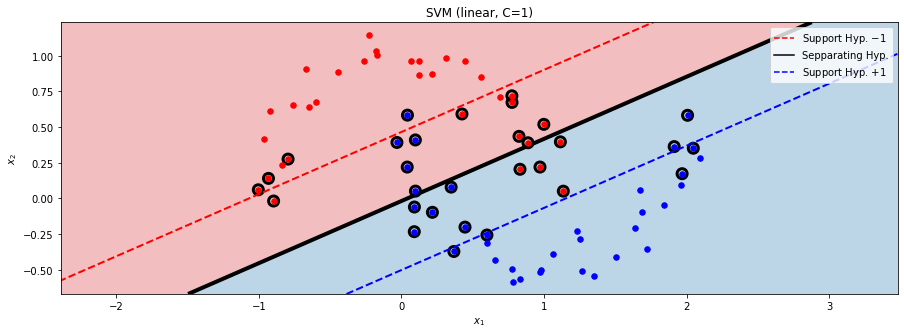

Sklearn model:


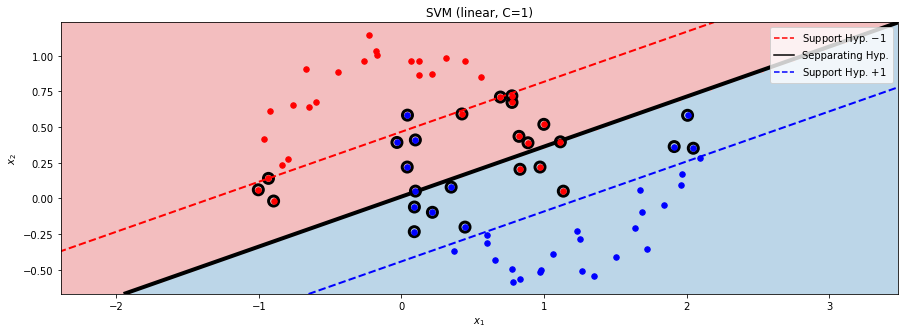

% of predicted classes that coincide in both models: 100.0 %
Accuracy score in MySVC: 86.66666666666667 %
Accuracy score in Sklearn: 86.66666666666667 %
Number of support vectors (for each class) in MySVC: [14 16]
Number of support vectors (for each class) in Sklearn: [14 13]
Linear model coefficients (w) in MySVC: [ 0.90014065 -2.06529409]
Linear model coefficients (w) in Sklearn: [[ 0.77096307 -2.19842572]]


In [83]:
compare_svc(x_tr, y_tr, x_te, y_te, kernel='linear')

We can see that we get the same predictions and score, but the number of support vectors and the linear coefficients are not the same. We can fix this by increasing the number of iterations and setting `tol=0` in the MySVC method, as suggested earlier.

Training time for MySVC: 809.6569360000033 ms
Training time for Sklearn: 1.3419360000028746 ms

MySVC model:


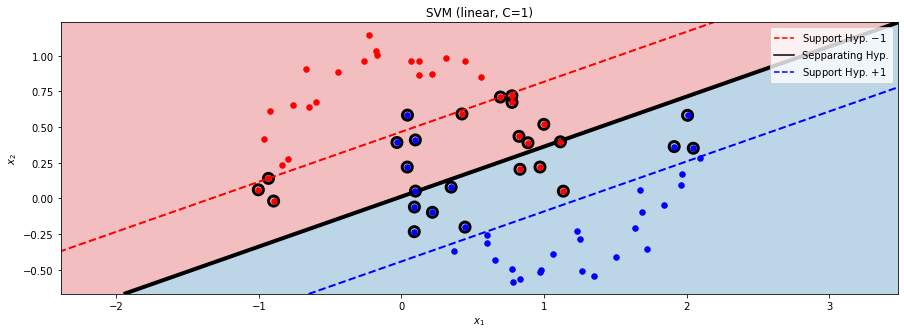

Sklearn model:


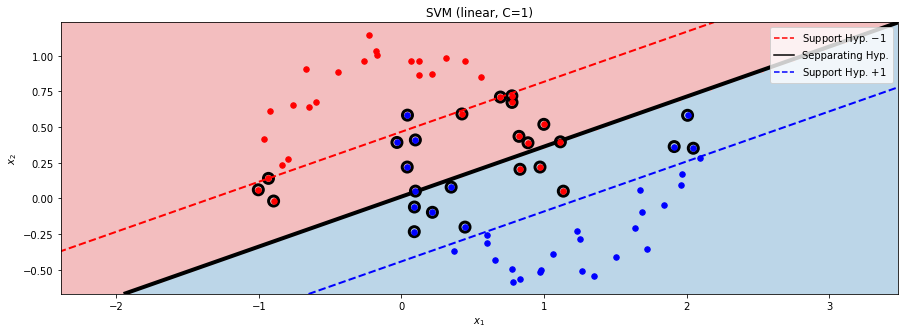

% of predicted classes that coincide in both models: 100.0 %
Accuracy score in MySVC: 86.66666666666667 %
Accuracy score in Sklearn: 86.66666666666667 %
Number of support vectors (for each class) in MySVC: [14 13]
Number of support vectors (for each class) in Sklearn: [14 13]
Linear model coefficients (w) in MySVC: [ 0.77096304 -2.19842573]
Linear model coefficients (w) in Sklearn: [[ 0.77096307 -2.19842572]]


In [84]:
compare_svc(x_tr, y_tr, x_te, y_te, kernel='linear', tol=0, max_iter=300)

Next we perform the same experiment but with the RBF kernel, which is defined by

$$
\mathcal{K}(\mathbf{x}, \mathbf{x'}) = \exp(-\gamma \|\mathbf{x}-\mathbf{x'}\|^2).
$$

Training time for MySVC: 380.8019159999958 ms
Training time for Sklearn: 1.11674200000067 ms

MySVC model:


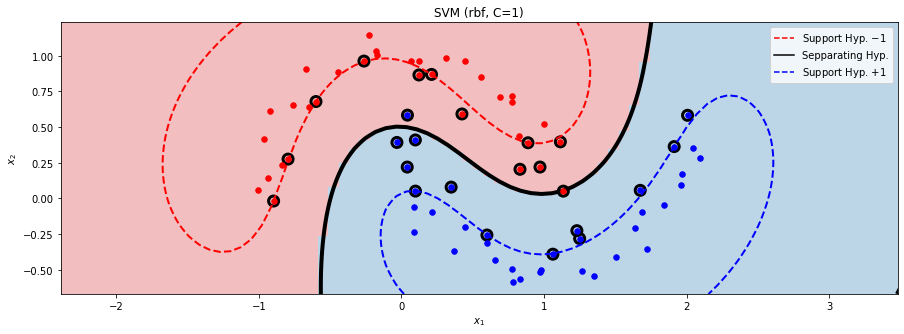

Sklearn model:


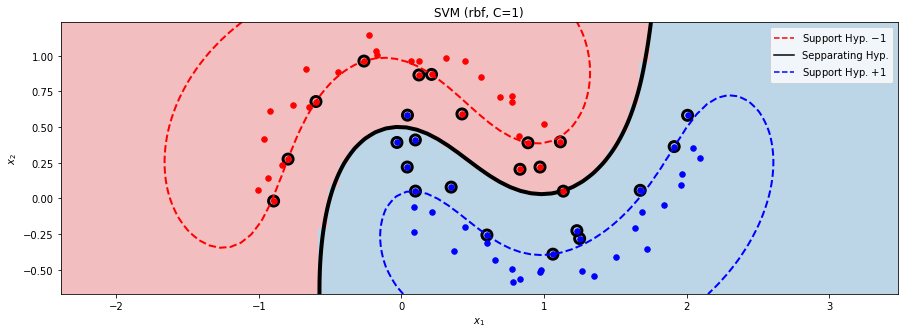

% of predicted classes that coincide in both models: 100.0 %
Accuracy score in MySVC: 96.66666666666667 %
Accuracy score in Sklearn: 96.66666666666667 %
Number of support vectors (for each class) in MySVC: [12 13]
Number of support vectors (for each class) in Sklearn: [12 13]


In [85]:
compare_svc(x_tr, y_tr, x_te, y_te, kernel='rbf', tol=0)

We observe that we get the exact same results as Sklearn's algorithm, save for the computation time. Finally, we try to pass a user-defined kernel, which in this case will be a homogeneous polynomial kernel of degree 5. It can be expressed as

$$
\mathcal{K}(\mathbf{x}, \mathbf{x'}) = (\mathbf{x}^T\mathbf{x})^5.
$$

Training time for MySVC: 323.40932999999694 ms
Training time for Sklearn: 2.955810999999642 ms

MySVC model:


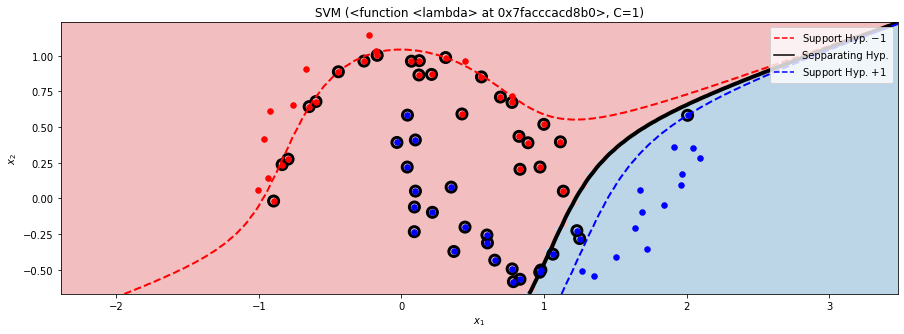

Sklearn model:


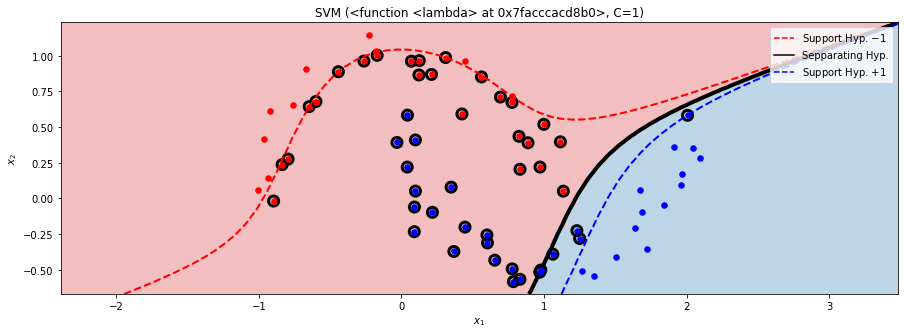

% of predicted classes that coincide in both models: 100.0 %
Accuracy score in MySVC: 80.0 %
Accuracy score in Sklearn: 80.0 %
Number of support vectors (for each class) in MySVC: [24 23]
Number of support vectors (for each class) in Sklearn: [24 23]


In [86]:
from sklearn.metrics.pairwise import polynomial_kernel

poly_kernel = lambda X, Y=None: polynomial_kernel(X, Y, degree = 5, coef0 = 0) 
compare_svc(x_tr, y_tr, x_te, y_te, kernel=poly_kernel, tol=0)

Of the three kernels tried, the RBF kernel is the winner, achieving a classification accuracy of 96% on the test set.

## Understanding the SVM

<div class="qst">

* Considering the model created with the `MySVC` class:
    * Extract the list of support vectors, explaining the followed approach.
    * Extract the list of training points bad and well classified, explaining the followed approach.
    * Extract the list of training points that lie over the supporting hyperplanes.
    * Extract the list of training points located on the wrong side of the supporting hyperplanes, but that are well classified.
* What are the conditions over the dual coefficients $\alpha_i$ that characterize the previous lists (if any)?

</div>

In [ ]:
decision = np.array(model_my.decision_function(x_tr))
clasification = np.sign(decision)
a = model_my.dual_coef_

# Puntos bien clasificados
x_tr[clasification == y_tr]

# Puntos mal clasificados
x_tr[clasification != y_tr]

# Puntos bien clasificados pero al lado erroneo del soporte
x_tr[(clasification == y_tr) & (decision < 1)]